In [331]:
import csv
import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy.stats as stats

In [67]:
org_df = pd.read_csv("by_org_results (3).csv", delimiter=";")

with open("by_repo_results (3).csv", "r", encoding='utf-8') as f:
  csvreader = csv.reader(f, delimiter=";")
  headers = next(csvreader)
  data = []
  for row in csvreader:
    if row[0] != " ":
      company_name = row[0]
    else:
      # if company_name in allowed_orgs:
        # print(row)
        row[0] = company_name
        data.append(row)

repo_df = pd.DataFrame(data=data, columns=headers)
repo_df["repo_stars"] = repo_df["repo_stars"].astype(np.int32)

repo_df

,organization,description,twitter_link,repo_name,repo_stars,repo_topics,repo_languages,repo_half_year_commits,repo_last_commit_date
0,ros-acceleration,,,community,60,"['cpu', 'fpga', 'gpu', 'hardware', 'hardware-a...","('%',)",0,2024-01-04T09:54:23Z
1,ros-acceleration,,,ament_vitis,7,[],"('CMake: 100.0%',)",0,2023-08-14T09:36:49Z
2,ros-acceleration,,,acceleration_firmware_kv260,10,"['acceleration', 'fpga', 'hardware', 'hardware...","('CMake: 100.0%',)",0,2022-11-09T11:32:38Z
3,ros-acceleration,,,acceleration_firmware,0,[],"('CMake: 100.0%',)",0,2021-09-09T08:17:35Z
4,ros-acceleration,,,acceleration_examples,41,"['fpga', 'gpu', 'hardware-acceleration', 'ros2']","('C++: 48.70051274748906%, Python: 40.05005593...",0,2023-10-25T12:24:05Z
...,...,...,...,...,...,...,...,...,...
8514,4am-robotics,,,pointcloud_to_laserscan,3,[],"('C++: 96.39305870157791%, CMake: 3.6069412984...",4,2024-08-05T08:01:31Z
8515,4am-robotics,,,cob_fiducials,0,[],"('C++: 95.3782530131704%, C: 3.408406450451121...",0,2024-03-18T09:08:23Z
8516,4am-robotics,,,robmuxinator,7,"['robotics', 'tmux', 'tools']","('Python: 96.42264429282685%, Nix: 3.577355707...",36,2024-11-05T11:50:22Z
8517,4am-robotics,,,cob_fiducials-release,0,[],"('%',)",0,2024-02-20T09:29:25Z


## 1. Языки с высокой долей использования коррелируют с популярностью репозиториев (по звёздам)

In [282]:
repo_languages = repo_df.copy()

#среднее количество звезд у каждого языка программирования

def extract_main_language(language_str):
    if language_str and isinstance(language_str, str):
        match = re.match(r"\('?(.*?)[:s]", language_str)
        if match:
            return match.group(1)
    return "Unknown"

repo_languages["main_language"] = repo_languages["repo_languages"].apply(lambda x: extract_main_language(x))

language_counts = repo_languages["main_language"].value_counts()

# Отбираем языки, которые используются более чем в 5 репозиториях
popular_languages = language_counts[language_counts > 10].index

# Считаем среднее количество звёзд только для отобранных языков
filtered_repo_languages = repo_languages[repo_languages["main_language"].isin(popular_languages)]
language_stars = filtered_repo_languages.groupby("main_language")["repo_stars"].mean().sort_values(ascending=False).reset_index()

# Выводим топ-20 языков
language_stars.head(30)

,main_language,repo_stars
0,Swift,299.863636
1,Dockerfile,171.796296
2,Go,125.375000
3,Objective-C,106.342105
4,CSS,81.696970
5,C,52.165217
6,C#,43.426752
7,Python,33.380062
8,C++,31.269836
9,Jupyter Notebook,17.616438


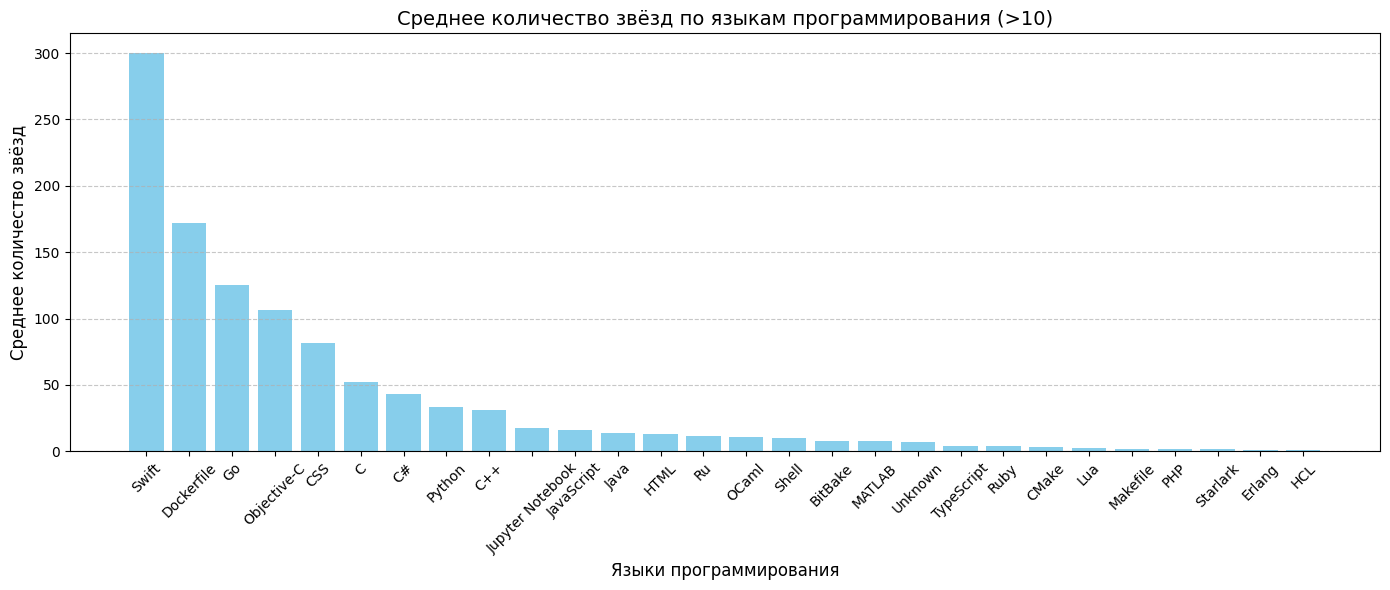

In [284]:
# Визуализация для топ-30 языков
top_languages = language_stars.head(30)

plt.figure(figsize=(14, 6))
plt.bar(top_languages["main_language"], top_languages["repo_stars"], color="skyblue")
plt.title("Среднее количество звёзд по языкам программирования (>10)", fontsize=14)
plt.xlabel("Языки программирования", fontsize=12)
plt.ylabel("Среднее количество звёзд", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [285]:
#количетсво использования языка программирования
language_count = repo_languages["main_language"].value_counts().sort_values(ascending=False).reset_index()

language_df = language_count.merge(language_stars[['main_language', 'repo_stars']], on = 'main_language')
language_df 

,main_language,count,repo_stars
0,C++,2924,31.269836
1,Python,1605,33.380062
2,Unknown,778,6.769923
3,C,690,52.165217
4,JavaScript,374,16.040107
5,CMake,323,3.458204
6,Shell,280,10.067857
7,Java,236,14.063559
8,C#,157,43.426752
9,HTML,154,13.253247


C:\Users\Мария\AppData\Local\Temp\ipykernel_4668\2678865706.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(language_df['main_language'], rotation=45, ha='right')


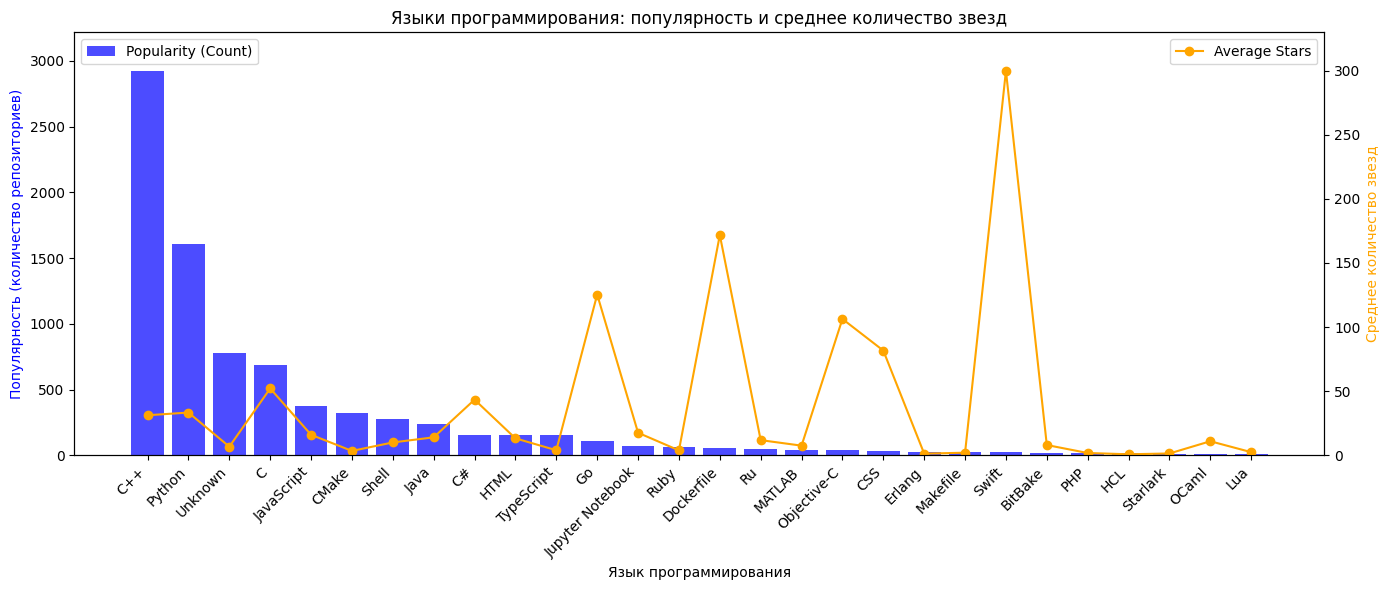

Корреляция между популярностью языка программирования и количеством звезд в репозитории с ним: -0.07


In [290]:
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.bar(language_df['main_language'], language_df['count'], color='blue', label='Popularity (Count)', alpha=0.7)
ax2 = ax1.twinx()
ax2.plot(language_df['main_language'], language_df['repo_stars'], color='orange', marker='o', label='Average Stars')

ax1.set_xlabel('Язык программирования')
ax1.set_ylabel('Популярность (количество репозиториев)', color='blue')
ax2.set_ylabel('Среднее количество звезд', color='orange')
ax1.set_ylim(0, max(language_df['count']) * 1.1)
ax2.set_ylim(0, max(language_df['repo_stars']) * 1.1)
plt.title('Языки программирования: популярность и среднее количество звезд')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Улучшаем подписи на оси X
ax1.set_xticklabels(language_df['main_language'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

correlation_language = language_df['count'].corr(language_df['repo_stars'])
print(f"Корреляция между популярностью языка программирования и количеством звезд в репозитории с ним: {correlation_language:.2f}")


Гипотеза не подвердилась - использование редких языков программирования может положительно влиять на звездность репозитория, а использование популярного языка программирования не гарантирует большое количество звезд. 

## 2. Частые коммиты (или недавние коммиты) положительно влияют на популярность (по звёздам)

In [94]:
repo_df[['repo_stars', 'repo_half_year_commits']].sort_values(by='repo_half_year_commits', ascending=False)

,repo_stars,repo_half_year_commits
1288,2,98
8021,69,96
7786,1,95
8416,0,95
7497,136,94
...,...,...
2992,0,0
2991,0,0
2990,0,0
2989,1,0


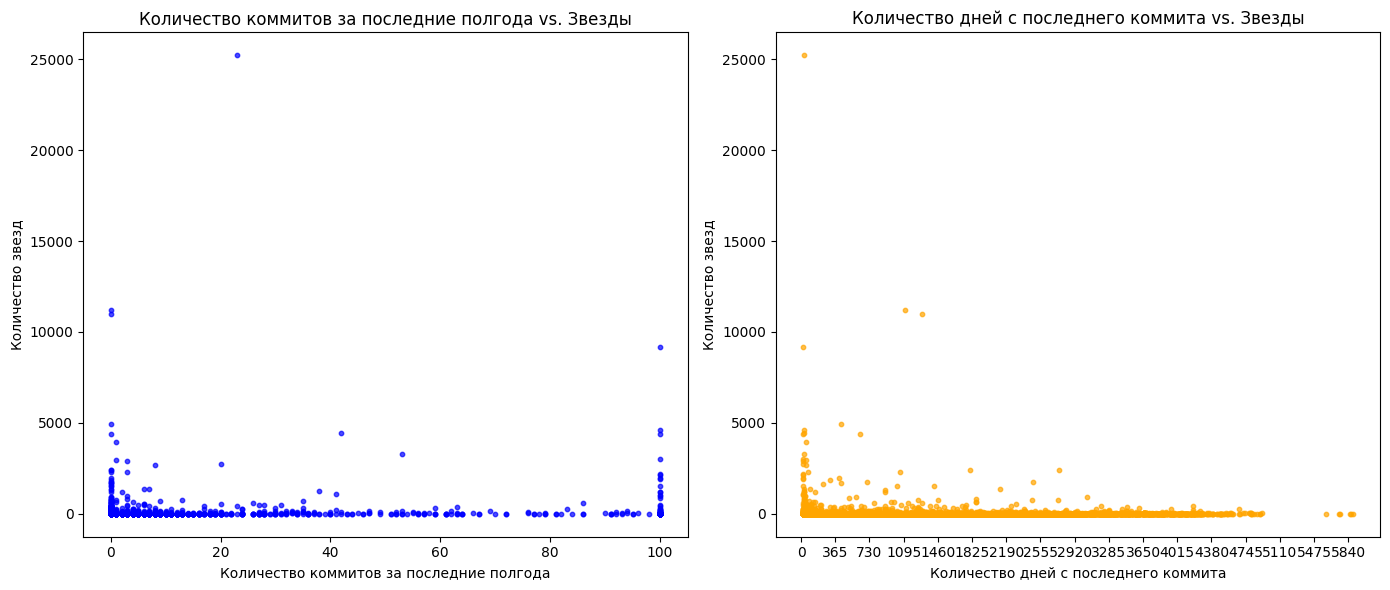

Корреляция между количеством коммитов за последние полгода и количеством звезд: 0.12
Корреляция между датой последнего коммита и количеством звезд: -0.06


In [138]:
commits_repo = repo_df[['repo_stars', 'repo_half_year_commits', 'repo_last_commit_date']].sort_values(by='repo_half_year_commits', ascending=False)
commits_repo['repo_half_year_commits'] = pd.to_numeric(commits_repo['repo_half_year_commits'], errors='coerce')
commits_repo['repo_last_commit_date'] = pd.to_datetime(commits_repo['repo_last_commit_date'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')

current_date = datetime.now()
def calculate_days_since_last_commit(date):
    if pd.isna(date): 
        return None  
    return (current_date - date).days

commits_repo['days_since_last_commit'] = commits_repo['repo_last_commit_date'].apply(calculate_days_since_last_commit)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(commits_repo['repo_half_year_commits'], commits_repo['repo_stars'], alpha=0.7, color='blue', s=10)
axs[0].set_title('Количество коммитов за последние полгода vs. Звезды')
axs[0].set_xlabel('Количество коммитов за последние полгода')
axs[0].set_ylabel('Количество звезд')

max_commits = commits_repo['repo_half_year_commits'].max()
xticks = np.arange(0, int(max_commits) + 10, 10)
plt.xticks(xticks)

axs[1].scatter(commits_repo['days_since_last_commit'], commits_repo['repo_stars'], alpha=0.7, color='orange', s=10)
axs[1].set_title('Количество дней с последнего коммита vs. Звезды')
axs[1].set_xlabel('Количество дней с последнего коммита')
axs[1].set_ylabel('Количество звезд')

max_days = commits_repo['days_since_last_commit'].max()
xticks = np.arange(0, int(max_days), 365)
plt.xticks(xticks)

plt.tight_layout()
plt.show()

correlation_commits1 = commits_repo['repo_half_year_commits'].corr(commits_repo['repo_stars'])
correlation_commits2 = commits_repo['days_since_last_commit'].corr(commits_repo['repo_stars'])

print(f"Корреляция между количеством коммитов за последние полгода и количеством звезд: {correlation_commits1:.2f}")
print(f"Корреляция между датой последнего коммита и количеством звезд: {correlation_commits2:.2f}")

In [327]:
commits_repo

,repo_stars,repo_half_year_commits,repo_last_commit_date,days_since_last_commit
1288,2,98,2024-10-17 10:43:55,53.0
8021,69,96,2024-09-03 06:38:26,97.0
7786,1,95,2024-11-17 01:36:47,22.0
8416,0,95,2024-10-14 07:00:09,56.0
7497,136,94,2024-10-17 07:12:29,53.0
...,...,...,...,...
2992,0,0,2013-07-20 14:02:02,4160.0
2991,0,0,2013-08-02 02:37:58,4147.0
2990,0,0,2013-07-21 13:10:28,4159.0
2989,1,0,2013-08-02 02:46:43,4147.0


## 3. Количество звёзд организации связано с количеством её репозиториев

Корреляция между количество звезд и количеством репозиториев: 0.06


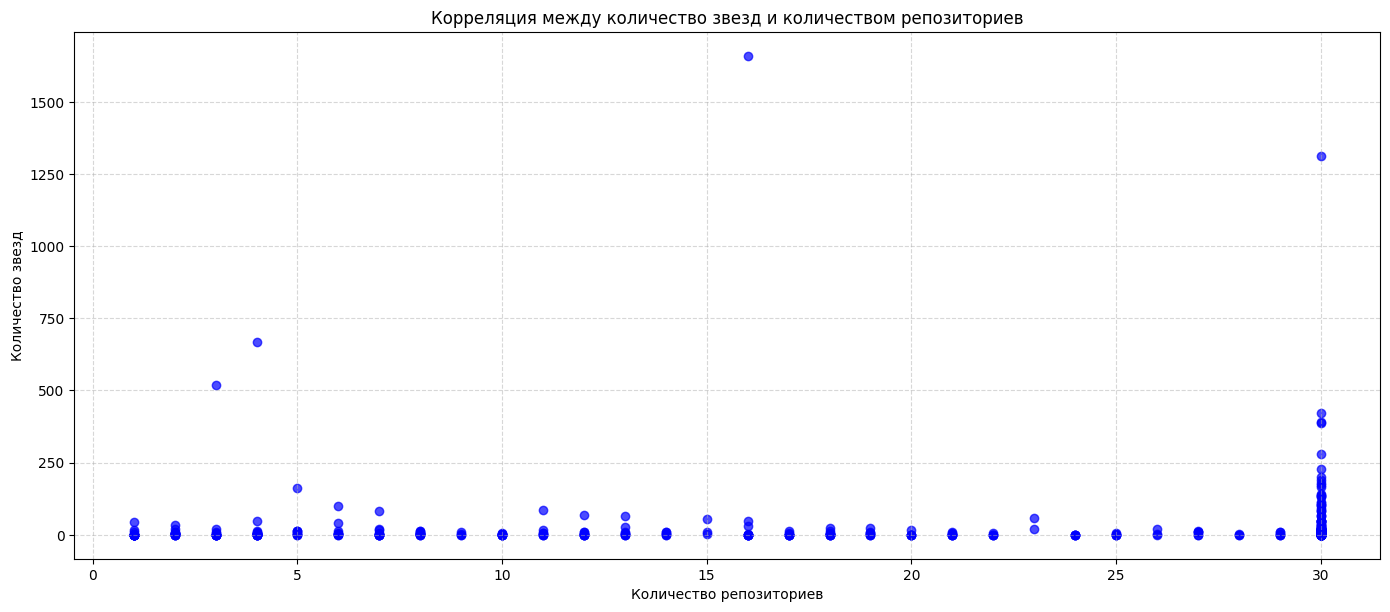

,organization,repo_count,total_stars
0,apolloauto,16,1658.500000
1,apple,30,1312.666667
2,boston-dynamics,4,668.000000
3,Fyusion,3,518.000000
4,canonical,30,420.466667
5,autowarefoundation,30,389.833333
6,sony,30,386.533333
7,nvidia,30,279.466667
8,ARM-software,30,226.900000
9,tryolabs,30,201.433333


In [310]:
repos_count_df = repo_df.groupby('organization').agg(
    repo_count=('organization', 'size'),  
    total_stars=('repo_stars', 'mean')         
).sort_values(by='total_stars', ascending=False).reset_index()

correlation_repos = repos_count_df['repo_count'].corr(repos_count_df['total_stars'])

print(f"Корреляция между количество звезд и количеством репозиториев: {correlation_repos:.2f}")

plt.figure(figsize=(14, 6))
plt.scatter(repos_count_df['repo_count'], repos_count_df['total_stars'], alpha=0.7, color='blue')
plt.xlabel('Количество репозиториев')
plt.ylabel('Количество звезд')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.title('Корреляция между количество звезд и количеством репозиториев')

plt.show()

repos_count_df.head(30)

## 4. Репозитории с поддержкой ROS получают больше звёзд

In [318]:
# Определим репозитории с поддержкой ROS, основываясь на 'repo_topics' или 'repo_name'
ros_repo = repo_df[['repo_name', 'repo_topics', 'repo_stars']]

# Проверяем наличие "ros" в названии репозитория (repo_name)
ros_repo.loc[:, 'has_ros_name'] = ros_repo['repo_name'].str.contains('ros', case=False, na=False)

# Проверяем наличие "ros" в топиках (repo_topics)
ros_repo.loc[:, 'has_ros_topic'] = ros_repo['repo_topics'].apply(lambda x: 'ros' in x if isinstance(x, list) else False)

# Объединяем оба условия
ros_repo.loc[:, 'has_ros_support'] = ros_repo['has_ros_name'] | ros_repo['has_ros_topic']
ros_repo = ros_repo.drop(['has_ros_name', 'has_ros_topic'], axis=1)

has_ros = ros_repo[ros_repo['has_ros_support'] == True]
no_ros = ros_repo[ros_repo['has_ros_support'] == False]

has_ros_avg_stars = has_ros['repo_stars'].mean()
no_ros_avg_stars = no_ros['repo_stars'].mean()

print(f"Среднее количество звезд у репозиториев с поддержкой ROS: {has_ros_avg_stars:.2f}")
print(f"Среднее количество звезд у репозиториев без поддержки ROS: {no_ros_avg_stars:.2f}")

print(no_ros)

Среднее количество звезд у репозиториев с поддержкой ROS: 10.14
Среднее количество звезд у репозиториев без поддержки ROS: 33.53
                        repo_name  \
0                       community   
1                     ament_vitis   
2     acceleration_firmware_kv260   
3           acceleration_firmware   
4           acceleration_examples   
...                           ...   
8514      pointcloud_to_laserscan   
8515                cob_fiducials   
8516                 robmuxinator   
8517        cob_fiducials-release   
8518                      vcstool   

                                            repo_topics  repo_stars  \
0     ['cpu', 'fpga', 'gpu', 'hardware', 'hardware-a...          60   
1                                                    []           7   
2     ['acceleration', 'fpga', 'hardware', 'hardware...          10   
3                                                    []           0   
4      ['fpga', 'gpu', 'hardware-acceleration', 'ros2']          41   


C:\Users\Мария\AppData\Local\Temp\ipykernel_4668\3294939470.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ros_repo.loc[:, 'has_ros_name'] = ros_repo['repo_name'].str.contains('ros', case=False, na=False)
C:\Users\Мария\AppData\Local\Temp\ipykernel_4668\3294939470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ros_repo.loc[:, 'has_ros_topic'] = ros_repo['repo_topics'].apply(lambda x: 'ros' in x if isinstance(x, list) else False)
C:\Users\Мария\AppData\Local\Temp\ipykernel_4668\3294939470.py:11: Se

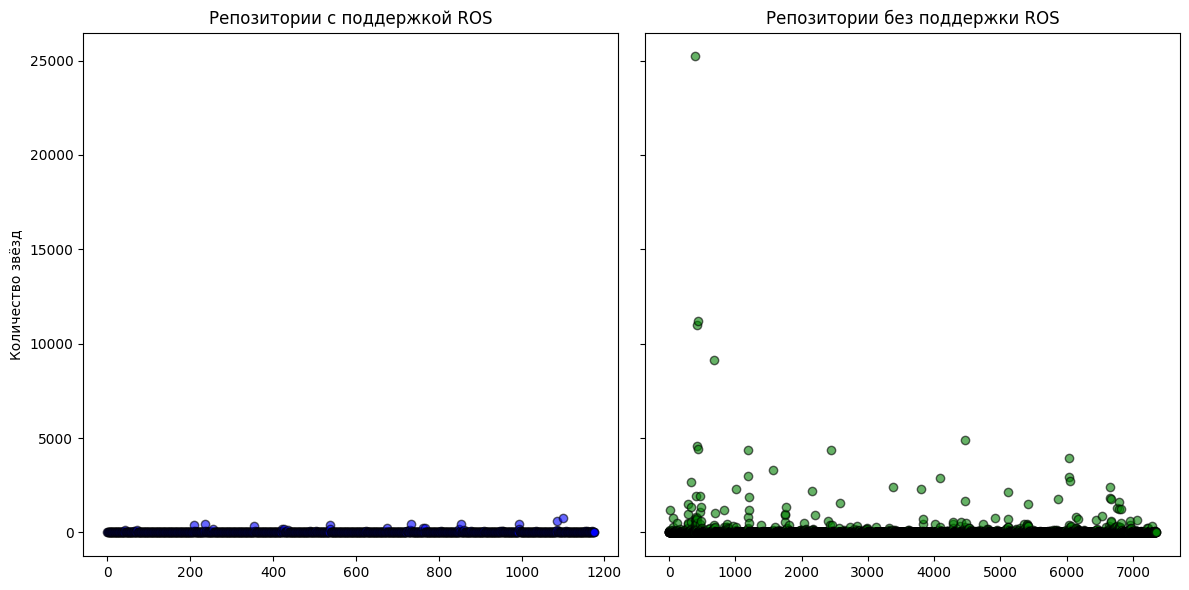

In [219]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].scatter(range(len(has_ros)), has_ros['repo_stars'], color='blue', alpha=0.6, edgecolor='black')
axes[0].set_title('Репозитории с поддержкой ROS')
axes[0].set_ylabel('Количество звёзд')

axes[1].scatter(range(len(no_ros)), no_ros['repo_stars'], color='green', alpha=0.6, edgecolor='black')
axes[1].set_title('Репозитории без поддержки ROS')

plt.tight_layout()
plt.show()

Гипотеза не подтвердилась - среднее количество звезд у репозиториев с поддержкой ROS значительно меньше.

In [316]:
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(has_ros['repo_stars'], no_ros['repo_stars'], equal_var=False)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_val:.2e}")

T-statistic: -4.68, P-value: 2.94e-06


In [314]:
ros_orgs = org_df[['organization', 'stars_count', 'ros_repos' ]]

ros_orgs.loc[:, 'ros_repos'] = ros_orgs['ros_repos'].apply(lambda x: eval(x) if isinstance(x, str) else x)

has_ros_orgs = ros_orgs[ros_orgs['ros_repos'].apply(lambda x: isinstance(x, list) and len(x) > 0)] 
no_ros_orgs = ros_orgs[ros_orgs['ros_repos'].apply(lambda x: isinstance(x, list) and len(x) == 0)]

has_ros_org_avg_stars = has_ros_orgs['stars_count'].mean()
no_ros_org_avg_stars = no_ros_orgs['stars_count'].mean()

print(f"Среднее количество звезд у репозиториев с поддержкой ROS: {has_ros_org_avg_stars:.2f}")
print(f"Среднее количество звезд у репозиториев без поддержки ROS: {no_ros_org_avg_stars:.2f}")

print(has_ros_orgs)

Среднее количество звезд у репозиториев с поддержкой ROS: 325.14
Среднее количество звезд у репозиториев без поддержки ROS: 675.69
         organization  stars_count  \
0    ros-acceleration          304   
1             Aceinna         1430   
3            accerion            0   
9     adlatusrobotics            0   
14           AeroVect            0   
..                ...          ...   
511    ZettaScaleLabs          460   
513             zivid          186   
514               zmp           20   
515     ZVISION-lidar           16   
516     3LawsRobotics            2   

                                             ros_repos  
0                [ros2_kria, isaac_ros_image_pipeline]  
1                         [aceinna_openrtk_ros_driver]  
3                           [gazebo_ros_2d_map_plugin]  
9                             [carebt_ros2, stage_ros]  
14   [ros2_numpy, ros2_message_converter, HesaiLida...  
..                                                 ...  
511          

In [320]:
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(has_ros_orgs['stars_count'], no_ros_orgs['stars_count'], equal_var=False)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_val:.2e}")

T-statistic: -1.63, P-value: 1.04e-01


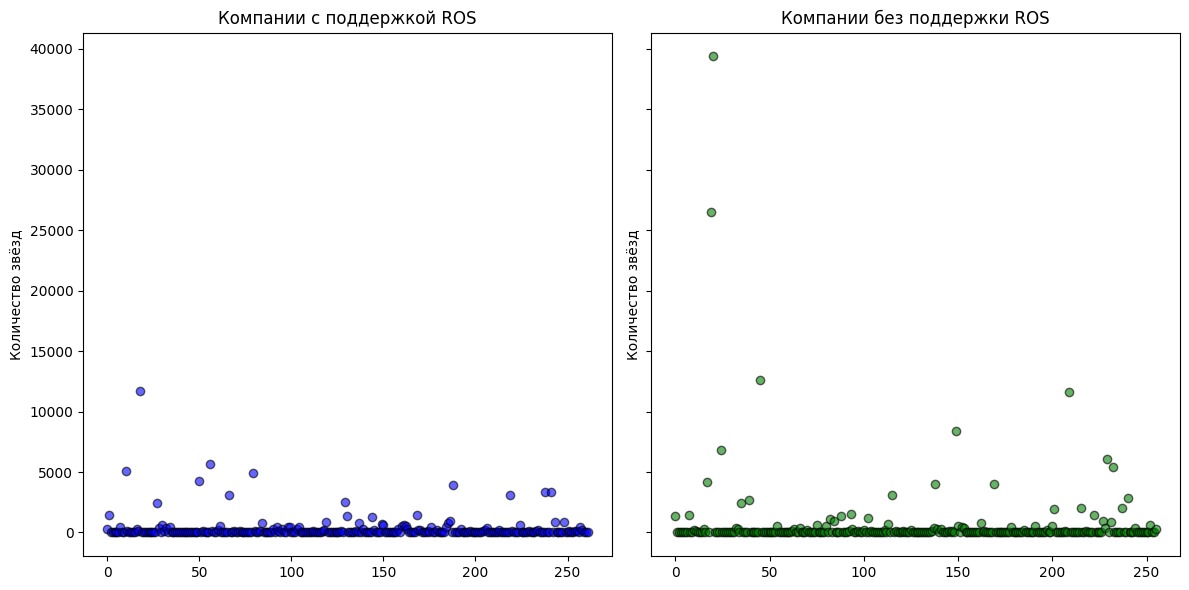

In [321]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].scatter(range(len(has_ros_orgs)), has_ros_orgs['stars_count'], color='blue', alpha=0.6, edgecolor='black')
axes[0].set_title('Компании с поддержкой ROS')
axes[0].set_ylabel('Количество звёзд')

axes[1].scatter(range(len(no_ros_orgs)), no_ros_orgs['stars_count'], color='green', alpha=0.6, edgecolor='black')
axes[1].set_title('Компании без поддержки ROS')
axes[1].set_ylabel('Количество звёзд')

plt.tight_layout()
plt.show()

## 8. Компании с более подробными (длинными) описаниями имеют больше звёзд в их репозиториях

In [325]:
with open("by_repo_results (3).csv", "r", encoding='utf-8') as f:
  csvreader = csv.reader(f, delimiter=";")
  headers = next(csvreader)
  data = []
  for row in csvreader:
    if row[0] != " ":
      company_name = row[0]
      data.append(row)
    else:
      # if company_name in allowed_orgs:
        # print(row)
        row[0] = company_name
        data.append(row)

repo2_df = pd.DataFrame(data=data, columns=headers)
repo2_df['repo_stars'] = pd.to_numeric(repo2_df['repo_stars'], errors='coerce')
repo2_df['repo_stars'] = repo2_df['repo_stars'].fillna(0)

description_repo = repo2_df[['organization', 'description', 'repo_stars']].drop_duplicates()
description_repo['length'] = description_repo['description'].apply(lambda x: len(str(x).split()))

description_repo = description_repo.groupby('organization').agg(
    length=('length', 'max'),
    total_stars=('repo_stars', 'sum')
).sort_values(by='total_stars', ascending=False).reset_index().tail(300)

description_repo

,organization,length,total_stars
217,MORAI-Autonomous,4,23.0
218,NOKOV-MOCAP,1,23.0
219,BonsaiRobotics,0,22.0
220,RightHandRobotics,0,21.0
221,builtrobotics,12,21.0
...,...,...,...
512,telemething,0,0.0
513,ArcheRobotics,24,0.0
514,BastianSolutionsRandD,7,0.0
515,BeeX-AS,0,0.0


Корреляция между длиной описания и количеством звёзд: 0.06


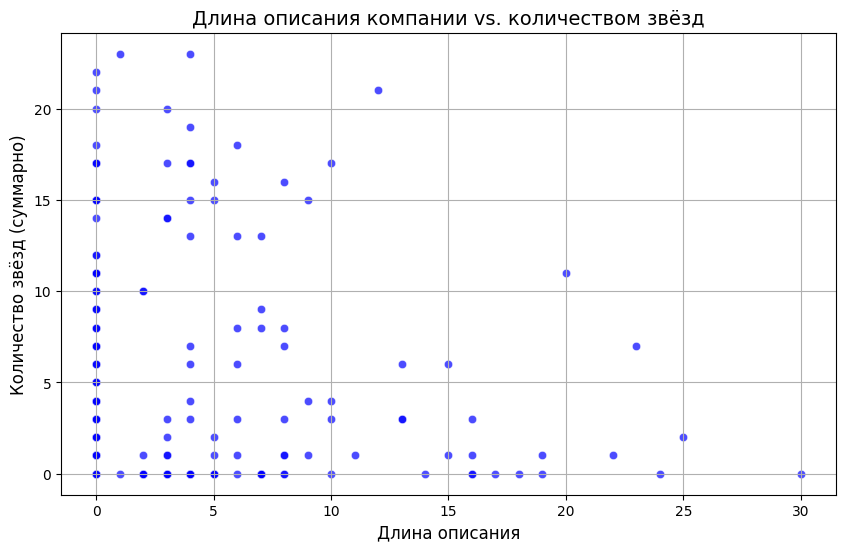

In [326]:
correlation_desk = description_repo['length'].corr(description_repo['total_stars'])
print(f"Корреляция между длиной описания и количеством звёзд: {correlation_desk:.2f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=description_repo, x='length', y='total_stars', alpha=0.7, color='blue')

plt.title("Длина описания компании vs. количеством звёзд", fontsize=14)
plt.xlabel("Длина описания", fontsize=12)
plt.ylabel("Количество звёзд (суммарно)", fontsize=12)
plt.grid(True)
plt.show()

Гипотеза не подтвердилась: подробное описание деятельности компании слабо влияет на звездность ее проэктов. 

## 9. Наличие тем в репозитории положительно влияет на его популярность

In [345]:
repo_topics = repo_df[['organization', 'repo_stars','repo_topics']]

repo_topics.loc[:, 'repo_topics'] = repo_topics['repo_topics'].apply(lambda x: eval(x) if isinstance(x, str) else x)

has_topics_repos = repo_topics[repo_topics['repo_topics'].apply(lambda x: isinstance(x, list) and len(x) > 0)].sort_values(by='repo_stars').head(900)
no_topics_repos = repo_topics[repo_topics['repo_topics'].apply(lambda x: isinstance(x, list) and len(x) == 0)]

has_topics_repos_avg_stars = has_topics_repos['repo_stars'].mean()
no_topics_repos_avg_stars = no_topics_repos['repo_stars'].mean()

print(f"Среднее количество звезд у репозиториев с темами: {has_topics_repos_avg_stars:.2f}")
print(f"Среднее количество звезд у репозиториев без тем: {no_topics_repos_avg_stars:.2f}")

print(has_topics_repos['repo_stars'].sort_values())

Среднее количество звезд у репозиториев с темами: 77.54
Среднее количество звезд у репозиториев без тем: 13.41
8437       0
8378       0
8          0
8469       0
4334       0
        ... 
5914    2148
2430    2209
4393    2288
7722    2405
371     2667
Name: repo_stars, Length: 900, dtype: int32


In [346]:
t_stat, p_value = stats.ttest_ind(has_topics_repos['repo_stars'], no_topics_repos['repo_stars'], nan_policy='omit')

print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}")

t-statistic: 13.23
p-value: 0.0000


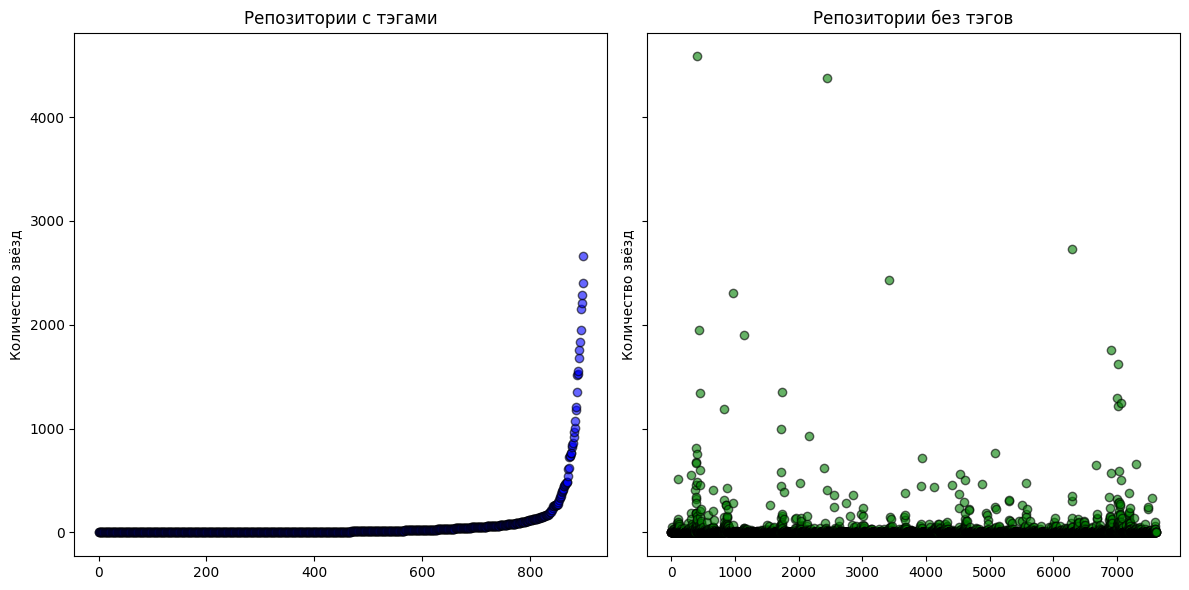

In [347]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].scatter(range(len(has_topics_repos)), has_topics_repos['repo_stars'], color='blue', alpha=0.6, edgecolor='black')
axes[0].set_title('Репозитории с тэгами')
axes[0].set_ylabel('Количество звёзд')

axes[1].scatter(range(len(no_topics_repos)), no_topics_repos['repo_stars'], color='green', alpha=0.6, edgecolor='black')
axes[1].set_title('Репозитории без тэгов')
axes[1].set_ylabel('Количество звёзд')

plt.tight_layout()
plt.show()